In [1]:
cd ..

/Users/austin/code/shiba


In [2]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.models import resnet18

from torch import nn

from shiba import Trainer
from shiba.callbacks import TensorBoard, Metric, Debug, Save
from shiba.metrics import categorical_accuracy
from shiba.vis import classification_snapshot
import matplotlib.pyplot as plt

%matplotlib inline

## Config

In [3]:
!rm -rf runs/ # clear tb logs

In [4]:
data_path = 'cifar'

## Load Data

In [5]:
train_dataset = CIFAR10(data_path, train=True, download=True, transform=ToTensor())
val_dataset = CIFAR10(data_path, train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Simple VGGlike Network

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_channels)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
model = SimpleNet(in_channels=3, out_channels=10)
criterion = nn.CrossEntropyLoss()

callbacks = [TensorBoard(snapshot_func=classification_snapshot),
             Metric(categorical_accuracy, 'accuracy'),
#              Debug(events=['on_batch_end']),
             Save('weights', interval=2)
            ]

In [8]:
trainer = Trainer(model, criterion, train_dataset, val_dataset, callbacks=callbacks)

## Callbacks

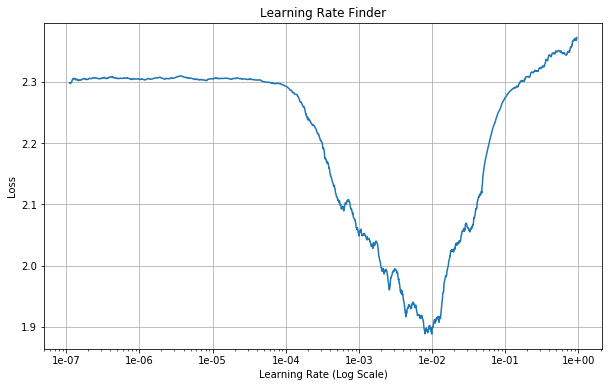

In [9]:
trainer.find_lr()

## Train

In [10]:
trainer.fit(epochs=2, lr=1e-3)